# Mixture Models + Model order selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd
from scipy.stats import multivariate_normal


%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [2]:
class my_GMM():
    
    def __init__(self, K):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.K_ = K
        self.pi_ = None
        
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        def compute_condition_prob_matrix(X, mu, Sigma, pi):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n,p = X.shape
            #initialize the conditional probability matrix with zeros
            cond_prob_matrix = np.zeros((X.shape[0], self.K_))
            #create a function that compute the gaussian PDF of a (n,1) vector
            f = lambda i,k : (2*np.pi)**(-p/2)*np.linalg.det(Sigma[k])**(-1/2)*np.exp(-(X[i]-mu[k]).T@np.linalg.inv(Sigma[k])@(X[i]-mu[k])/2)

            for i in range(X.shape[0]):
                sum_ = sum([pi[j]*f(i,j) for j in range(self.K_)])
                for k in range(self.K_):
                    cond_prob_matrix[i][k] = pi[k] * f(i,k)/sum_
            return cond_prob_matrix
        
        n,p = X.shape
        self.cond_prob_ = np.zeros((X.shape[0], self.K_))
        
        #initialize with kmeans
        kmeans = KMeans(n_clusters=self.K_, random_state=0).fit(X)
        means = []
        covs = []
        self.pi_ = []
        for k in range(self.K_):
            x = X[np.where(kmeans.labels_ == k)[0],:]
            self.pi_.append(len(x)/n)
            means.append(np.mean(x, axis=0))
            covs.append(np.cov(x.T))
        self.mu_ = means
        self.Sigma_ = covs
            
            
        iterations=1
        difference = 1
        
        while abs(difference)>1e-6:
            #----------E-STEP-----------------
            cond_prob_matrix = compute_condition_prob_matrix(X,self.mu_,self.Sigma_,self.pi_)
            difference = np.linalg.norm(self.cond_prob_ - cond_prob_matrix)
            self.cond_prob_ = cond_prob_matrix
            #Compute the N
            N = np.sum(self.cond_prob_, axis=0)
            
            #----------M Step-------------------
            #Initialize the mean vector with zeros
            self.mu_ = np.zeros((self.K_, p))
            #Update the mean vector
            for k in range(self.K_):
                for i in range(n):
                    self.mu_[k] += self.cond_prob_[i][k] * X[i]
            self.mu_ = [1/N[k]*self.mu_[k] for k in range(self.K_)]
            # Initiatize the list of the covariance matrices
            self.Sigma_ = [np.zeros((p,p)) for k in range(self.K_)]
            # Update the covariance matrices
            for k in range(self.K_):
                self.Sigma_[k] = np.cov(X.T, aweights=(self.cond_prob_[:, k]), ddof=0)
            self.Sigma_ = [1/N[k]*self.Sigma_[k] for k in range(self.K_)]
            # Updating the pi list
            self.pi_ = [N[k]/n for k in range(self.K_)]
            
            
            iterations+=1
        #Update labels
        self.labels_ = np.argmax(self.cond_prob_, axis=1)
        # Return self
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        # TODO
        probas = self.compute_proba(X)
        #for proba in probas:
        #    max_index = int(np.where(proba == np.max(proba))[0])
        #    clusters.append(self.labels_[max_index])
        return np.argmax(probas, axis=1)
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        # TODO
        #create a function that compute the gaussian PDF of a (n,1) vector
        #f = lambda n,k : (2*np.pi)**(-len(X[n])/2)*np.linalg.det(self.Sigma_[k])**(-1/2)*np.exp(-np.dot(np.dot((X[n]-self.mu_[k]).T, np.linalg.inv(self.Sigma_[k])), (X[n]-self.mu_[k]))/2)
        f = lambda i,k : (2*np.pi)**(-len(X[i])/2)*np.linalg.det(Sigma[k])**(-1/2)*np.exp(-(X[i]-mu[k]).T@np.linalg.inv(Sigma[k])@(X[i]-mu[k])/2)
        probas = np.zeros((X.shape[0], self.K_))
        for i in range(len(X)):
            for k in range(self.K_):
                probas[i,k] = f(i,k)
        return probas

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

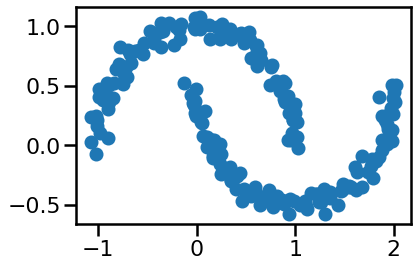

In [3]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

In [4]:
#initialize and fit gmm with 2 components on moon data
gmm = my_GMM(K=2)
gmm.fit(Xmoon)
#initalize and fit kmeans on moon data
kmeans = KMeans(n_clusters=2, random_state=0).fit(Xmoon)

Text(0.5, 1.0, 'Clusters with Kmean')

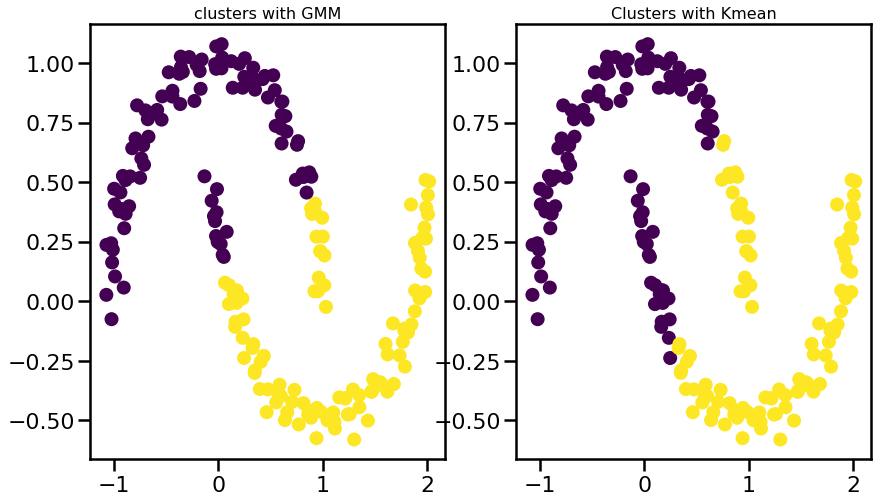

In [5]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].scatter(Xmoon[:,0], Xmoon[:,1], c=gmm.labels_)
ax[0].set_title('clusters with GMM', size=16)

ax[1].scatter(Xmoon[:,0], Xmoon[:,1], c=kmeans.labels_)
ax[1].set_title('Clusters with Kmean', size=16)

**Remark** <br>
We can clearly see that the clustering result of the GMM are better than Kmeans. 

### Second Part
 
- Select the number of clusters using the model order selection methods from the lecture (AIC, BIC)

In [ ]:
def compute_likelihood(X,K,mu,sigma):
    """
    Computes the likelihood of iid multivariate gaussians 
    """
    likelihood=0
    for i in range(X.shape[0]):
        lh=0
        for k in range(K):
            density = multivariate_normal(mu[k],sigma[k]).pdf(X[i])
            #dens=density_k.pdf(X[i])
            lh+=pi[k]* density
        likeli+=np.log(lh)
    return likelihood

def compute_aic(X,K):
    gmm = my_GMM(K=K)
    gmm.fit(X)
    likelihood = compute_likelihood(X,K,gmm.mu_,gmm.Sigma_)
    return likelihood - 3*K - 1
def compute_bic(X,K):
    gmm = my_GMM(K=K)
    gmm.fit(X)
    likelihood = compute_likelihood(X,K,gmm.mu_,gmm.Sigma_)
    return likelihood - 0.5*(3*K-1)*X.shape[0]


#Try on our data
data = pd.read_csv('./Data/data_MM_1.csv', header=None)
data = np.array(data)
n_components_range = range(1, 7)
aic=[]
bic=[]
for n_components in n_components_range:
    bic.append(compute_bic(data,n_components))
    aic.append(compute_aic(data,n_components))
t1=time.time()


Above we tried to compute the AIC and BIC using our gmm method. But we have a got an error because the covariance matrix isn't invertible apparently. We will try with scickit-Learn implemented AIC and BIC methods in the GaussianMixture class as they should be able to handle this problem.

In [7]:
from sklearn.mixture import GaussianMixture
data = pd.read_csv('./Data/data_MM_1.csv', header=None)
data = np.array(data)
n_components_range = range(1, 7)
aic=[]
bic=[]
for n_component in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_component)
    gmm.fit(data)
    bic.append(gmm.bic(data))
    aic.append(gmm.aic(data))

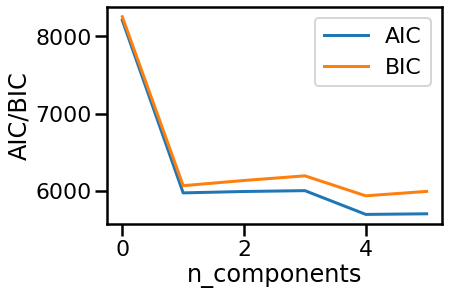

In [8]:
plt.figure()
plt.plot(aic,label="AIC")
plt.plot(bic,label="BIC")

lines = plt.gca().get_lines()
include = [0,1]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.ylabel('AIC/BIC')
plt.xlabel('n_components')
plt.show()

In [9]:
print("Number of clusters using BIC : ", np.argmin(bic)+1)
print("Number of clusters using AIC : ", np.argmin(aic)+1)

Number of clusters using BIC :  5
Number of clusters using AIC :  5


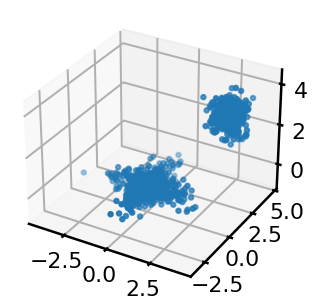

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:,0],data[:,1],data[:,2])
plt.show()

From the 3D plotting we can observe the existing of 2 clusters.<br>
Using the model order selection, we find that an optimal value for the number of components is 5. In fact, we can see that there are some outliers in the plotting that may increase the number of clusters and thus mistaken the AIC/BIC.

- Select the number of clusters using the model order reduction methods from the lecture (distance, correlation and parameter criteria)

In [ ]:
# TODO

Do these two methods (order selection and reduction) agree on the final number of clusters for the two given datasets (data-MM-i.csv)? Does it make sense?

Compare the results and the computational time. Try to visually validate your results.

Comment. 

In [22]:
#load data, header=None to not put data value as column names
data = pd.read_csv('./Data/data_MM_1.csv', header=None)
data = np.array(data)

**Distance Criterion**

In [23]:
#initialize GMM with 10 clusters
n_clusters = 10
gmm = my_GMM(K=n_clusters)
#fit the gmm to our data
gmm.fit(data)
#labels
labels = gmm.labels_

#create a list of cluster means
mean = []
for n_cluster in range(10):
    mean.append(np.mean(data[labels==n_cluster],axis=0))

def merge(mean, labels,i,j):
    """
    merge cluster i and cluster j
    update mean and labels
    """
    #update means
    n_i = sum(labels==i)
    n_j = sum(labels==j)
    new_mean = (n_i*mean[i] + n_j*mean[j])/(n_i + n_j)
    mean[i] = new_mean
    del mean[j]
    for k in range(len(labels)):
        if labels[k]==j:
            labels[k]=i
    return mean, labels

<ipython-input-2-1feba8e640f9>:53: RuntimeWarning: invalid value encountered in double_scalars
  cond_prob_matrix[i][k] = pi[k] * f(i,k)/sum_


In [24]:
distance_thresh = 0.5
merged=True 
while merged:
    merged = False
    nc = n_clusters
    
    for i in range(len(mean)-1):
        for j in range(i+1,len(mean)):
            if (i<len(mean)) and (j<len(mean)):
                if np.linalg.norm(mean[i]-mean[j])>distance_thresh:
                    mean, labels = merge(mean,labels,i,j)
                    nc-=1
                    merged = True
                    print("merging")

merging
merging
merging
merging
merging
merging
merging


<ipython-input-23-bc0de8f29eae>:22: RuntimeWarning: invalid value encountered in true_divide
  new_mean = (n_i*mean[i] + n_j*mean[j])/(n_i + n_j)


In [25]:
mean

[array([1.99397005, 1.66679124, 1.75833143]),
 array([nan, nan, nan]),
 array([nan, nan, nan])]

The fact that our Covariance matrix is not invertible is yielding calculations errors. <br>
I did not have time, but this problem might be solved by adding small positive values to the diagonal elements in the covariance matrix.

## Application

You are going to work with the following data:

shape: (1797, 64)


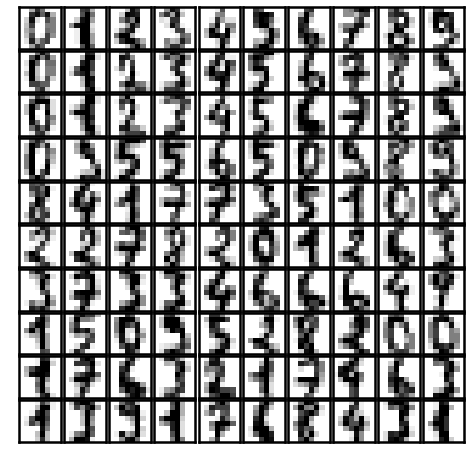

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. Finally, sample from every class and visualize to get an idea of what each cluster corresponds to. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [13]:
# TODO
# TODO
from sklearn.decomposition import PCA

X = digits.data

pca = PCA(n_components=15)
X_pca = pca.fit_transform(X)

aic=[]
bic=[]
n_components_range = range(1,15)
    
for n_component in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_component)
    gmm.fit(data)
    bic.append(gmm.bic(data))
    aic.append(gmm.aic(data))

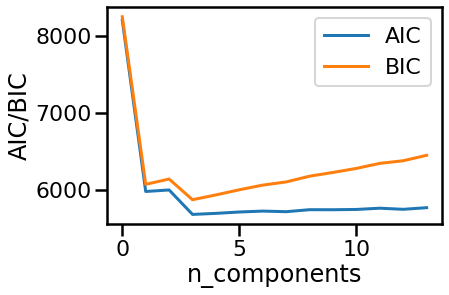

In [14]:
plt.figure()
plt.plot(aic,label="AIC")
plt.plot(bic,label="BIC")

lines = plt.gca().get_lines()
include = [0,1]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.ylabel('AIC/BIC')
plt.xlabel('n_components')
plt.show()

Here we can see that the BIC and AIC fave similar value up until values for 4 clusters. For values for clusters more than 4, the BIC increases and diverge from the optimal value of 10 components in our case. <br>
The AIC values are almost stable for components more than 5. The value of BIC at our optimal number of components = 10 is more and a less minimal. Hence the AIC is better in determining the true number of unknown clusters in this case.
May the reason behind this is tha the criteria information BIC is harsher at penalizing complexity.

In [15]:
optimal_n_components =10
gmm = my_GMM(K=optimal_n_components)
gmm.fit(X_pca)
#preds = gmm.predict(X_reduced)

<ipython-input-2-1feba8e640f9>:53: RuntimeWarning: invalid value encountered in double_scalars
  cond_prob_matrix[i][k] = pi[k] * f(i,k)/sum_


cluster 1 



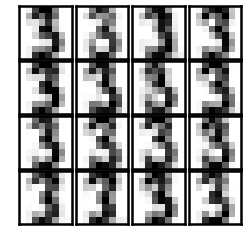

TypeError: 'list' object is not callable

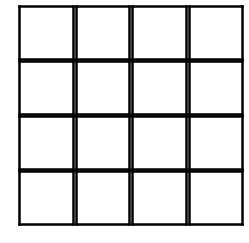

In [21]:
from random import sample

n_samples = 4
for component in range(optimal_n_components) : 
    fig, ax = plt.subplots(n_samples, n_samples, figsize=(4,4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    args = np.where(gmm.labels_ == component+1 )[0]
    sample = sample(set(args),n_samples**2)
    X_inv = pca.inverse_transform(X_pca[sample])
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(X_inv[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    print ('cluster {} \n'.format(component+1))
    plt.show()

I got an error that I couldn't solve.<br>
But we can see from that the cluster of number "3" contain many representation of 3 so the clustering was done correctly.